# Model calibration

In [1]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv

load_dotenv()
data_path = os.getenv('TRAINING_DATA')
df_train = pd.read_csv(data_path)
df_train = df_train.drop(columns = 'Studio')
df_train.columns

Index(['Sesso', 'Diabete', 'ESRD', 'Eta1', 'Prot1', 'Creat1', 'Epi1',
       'Colesterolo1', 'Hb1', 'Ca1', 'P1', 'BMI1', 'ckd_cause_hypertens',
       'ckd_cause_diabet', 'ckd_cause_glom_dis', 'ckd_cause_tubul_inter',
       'ckd_cause_pkd', 'esrd_upper', 'esrd_lower'],
      dtype='object')

In [2]:
# Import the results of the feature selection
import json

with open('raw_results/feature_selection_results.json') as f:
    var_dict = json.load(f)

In [3]:
df_feat_import = pd.DataFrame({'feat': var_dict['feat'], 'c_index': var_dict['c_index']})
df_feat_import['c_index'] = df_feat_import['c_index'].round(2)
selected_feat_0 = list(df_feat_import['feat'])[:np.argmax(df_feat_import['c_index']) + 1]
selected_feat_1 = list(df_feat_import['feat'])[:np.argmax(df_feat_import['c_index']) + 3]
print(selected_feat_0)
print(selected_feat_1)

['Epi1', 'Prot1', 'BMI1', 'Eta1', 'P1', 'Ca1']
['Epi1', 'Prot1', 'BMI1', 'Eta1', 'P1', 'Ca1', 'Hb1', 'Colesterolo1']


In [4]:
best_params_0 = var_dict['best_hyperparams'][np.argmax(df_feat_import['c_index'])]
best_params_1 = var_dict['best_hyperparams'][np.argmax(df_feat_import['c_index'])+2]
print(best_params_0)
print(best_params_1)

['extreme', 0.1, [8, 10], 30, [1.0, 3.0]]
['extreme', 0.1, [8, 10], 50, [1.0, 3.0]]


In [5]:
labelcols = {
    'lower': 'esrd_lower',
    'upper': 'esrd_upper'
}

In [6]:
df_train_0 = df_train[list(selected_feat_0 + [labelcols['lower'], labelcols['upper']])]
df_train_1 = df_train[list(selected_feat_1 + [labelcols['lower'], labelcols['upper']])]

In [7]:
print(df_train_0.shape)
print(df_train_1.shape)

(3599, 8)
(3599, 10)


In [8]:
print(df_train_0.columns)
print(df_train_1.columns)

Index(['Epi1', 'Prot1', 'BMI1', 'Eta1', 'P1', 'Ca1', 'esrd_lower',
       'esrd_upper'],
      dtype='object')
Index(['Epi1', 'Prot1', 'BMI1', 'Eta1', 'P1', 'Ca1', 'Hb1', 'Colesterolo1',
       'esrd_lower', 'esrd_upper'],
      dtype='object')


In [9]:
import bagging
from sklearn.model_selection import KFold, StratifiedKFold
import lifelines
from sklearn.metrics import mean_absolute_error
from itertools import product
from scipy import stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch


class BaggingTimeCalibrate():
    
    def __init__(self, n_splits=5, plot_lim=(0,200), verbose=False, early_stopping_rounds=10, num_boost_round=100):

        self.early_stopping_rounds = early_stopping_rounds
        self.num_boost_round = num_boost_round
        self.n_splits = n_splits
        self.plot_lim = plot_lim
        self.verbose = verbose
    
    def count_has_less_than_min_cases(self, counts, min_cases):
        if any(counts < min_cases):
            return True
        else:
            return False
    
    def merge_intervals(self, interval1, interval2):
        return pd.Interval(left=min(interval1.left, interval2.left), right=max(interval1.right, interval2.right), closed='both')

    def merge_small_bins(self, df, column, min_cases):
    
        counts = df[column].value_counts(sort=True)
    
        counts = counts[counts != 0]
        counts = counts.sort_index(ascending = False)
        indices = counts.index
        index_right = indices[0].right
        new_bins = []

        while self.count_has_less_than_min_cases(counts, min_cases):
            i = 0
            for index, count in counts.items():
                if count < min_cases:
                    if i == len(counts):
                        merge_with_interval = counts.index[i-1]
                    else:
                        merge_with_interval = counts.index[i+1]
                    
                    new_interval = self.merge_intervals(interval1 = merge_with_interval, interval2 = index)
                    new_count = count + counts[merge_with_interval]
                    add_series = pd.Series([new_count], index = [new_interval])
                    counts = counts.drop([merge_with_interval, index])
                    counts = pd.concat([add_series, counts])
                    break
                else:
                    i += 1

        left_bounds = [interval.left for interval in counts.index]
        right_bounds = [interval.right for interval in counts.index]
        all_bounds = sorted(set(left_bounds + right_bounds))
        df[column] = pd.cut(df['real'], bins = all_bounds)
    
        return df, all_bounds

    def bagging_grid_search(self, dfs, params, random_states, labelcols, line_colors):

        param_combinations = list(product(*params.values()))
    
        df_result_c_index = pd.DataFrame()
        df_result_censoring_accuracy = pd.DataFrame()
        df_result_mae = pd.DataFrame()
        df_result_r_2 = pd.DataFrame()
    
        best_c_index = 0.5
        calibration_metrics = {}

        for i, param_combo in enumerate(param_combinations):
            current_params = dict(zip(params.keys(), param_combo))
            params_to_test = current_params
            current_params = {
                'objective': current_params.get('objective', 'survival:aft'),
                'eval_metric': current_params.get('eval_metric', 'aft-nloglik'),
                'aft_loss_distribution': current_params.get('aft_loss_distribution', 'normal'),
                'aft_loss_distribution_scale': current_params.get('aft_loss_distribution_scale', '1.2'),
                'tree_method': current_params.get('tree_method', 'hist'),
                'learning_rate': current_params.get('learning_rate', 0.01),
                'max_depth': current_params.get('max_depth', [8,10]),
                'booster':current_params.get('booster', 'gbtree'),
                'subsample': current_params.get('subsample', 1.0),
                'min_child_weight': current_params.get('min_child_weight', 1.0),
                'colsample_bynode': current_params.get('colsample_bynode', 1.0),
                'n_models': current_params.get('n_models', 3),
                'subset_fraction': current_params.get('subset_fraction', 1.0)
                }
        
            c_indices = {}
            r_2s = {}
            maes = {}
            censored_accuracies = {}
            plot_dfs = {}

            for i_df, df in enumerate(dfs):
                if i_df == 0:
                    current_params['n_models'] = 30
                else:
                    current_params['n_models'] = 50
                print(current_params)
                c_indices[str('df_' + str(i_df))] = []
                r_2s[str('df_' + str(i_df))] = []
                maes[str('df_' + str(i_df))] = []
                censored_accuracies[str('df_' + str(i_df))] = []
                plot_dfs[str('df_' + str(i_df))] = []
                
                for random_state in random_states:
                    
                    kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=random_state)

                    event_times_all = []
                    event_observed_all = []
                    predicted_all = []

                    plot_dfs_fold = []
            
                    for train_idx, test_idx in kf.split(df):
                
                        kf_train = df.iloc[train_idx]
                        kf_test = df.iloc[test_idx]
                        model = bagging.BaggingXGBRegressor(params=current_params, labelcols=labelcols)
                
                        model.train(kf_train, early_stopping_rounds=self.early_stopping_rounds, num_boost_round=self.num_boost_round, verbose_eval=None)
            
                        pred = np.round(np.mean(model.predict(kf_test, output_margin = False), axis = 0), 2)
                
                        event_times = kf_test['esrd_lower'].to_numpy()
                        event_observed = (kf_test['esrd_upper'] == kf_test['esrd_lower']).astype(int).to_numpy()
                
                        c_index = lifelines.utils.concordance_index(event_times, pred, event_observed)
                        c_indices[str('df_' + str(i_df))].append(round(c_index, 3))

                        r_2 = round(r2_score(event_times[np.where(event_observed == 1)], pred[np.where(event_observed == 1)]), 2)
                        r_2s[str('df_' + str(i_df))].append(r_2)
                        mae = round(mean_absolute_error(event_times[np.where(event_observed == 1)], pred[np.where(event_observed == 1)]), 1)
                        maes[str('df_' + str(i_df))].append(mae)
                        censored_accuracy = round((pred[np.where(event_observed == 0)] > event_times[np.where(event_observed == 0)]).sum() / len(pred[np.where(event_observed == 0)]), 2)
                        censored_accuracies[str('df_' + str(i_df))].append(censored_accuracy)
                
                        if self.verbose:
                            # Visualize the real vs. predicted times
                            df_combined = pd.DataFrame({'real': event_times[np.where(event_observed == 1)], 'predicted': pred[np.where(event_observed == 1)]})
                            plot_dfs_fold.append(df_combined)
            
                    plot_dfs[str('df_' + str(i_df))].append(pd.concat(plot_dfs_fold, ignore_index=True))
            
            if self.verbose:
                
                for i_plot_df, plot_dfs_iter in enumerate(plot_dfs):
                    if i_plot_df == 0:
                        fig, ax = plt.subplots(figsize = (6.5, 6.0))
                        ax_density = ax.twinx()
                        sns.histplot(plot_dfs[plot_dfs_iter][0]['real'], fill=True, color='gray', linewidth = 0.0, alpha=0.35, ax=ax_density, bins = np.linspace(0,200,11), zorder=1)
                
                        ax_density.set_yticks(np.linspace(0,350, 8))
                        ax_density.spines['right'].set_visible(False)
                        ax_density.set_ylabel('Number of participants')
            
                        ax.plot([self.plot_lim[0], self.plot_lim[1]], [self.plot_lim[0], self.plot_lim[1]], color = "darkgray", linestyle = "-", linewidth = 2.0, zorder = 1)

                        handles = []
                    
                    for i, df_iter in enumerate(plot_dfs[plot_dfs_iter]):
                        df_iter['calibration_bins'] = pd.cut(df_iter['real'], bins = np.linspace(0,200,11))
                        df_iter, bins_nat = self.merge_small_bins(df_iter, 'calibration_bins', min_cases=5)
                        mean_real = df_iter.groupby('calibration_bins', observed = True)['real'].mean().to_numpy()
                        mean_predicted = df_iter.groupby('calibration_bins', observed = True)['predicted'].mean().to_numpy()
                        line, = ax.plot(mean_real,
                                        mean_predicted,
                                        label = str(str(plot_dfs_iter) + ': ' + str(random_states[i])),
                                        marker = "o",
                                        linestyle = "-",
                                        color = line_colors[i_plot_df],
                                        linewidth = 2.5,
                                        zorder = 2)
                        handles.append(line)
                
                ax.set_xlim(self.plot_lim[0], self.plot_lim[1])
                ax.set_ylim(self.plot_lim[0], self.plot_lim[1])
                ax.set_xlabel("True time to ESKD (months)")
                ax.set_ylabel("Predicted time to ESKD (months)")
                patch = Patch(color='gray', alpha=0.35, label='Training data')
                handles.append(patch)
                ax.legend(handles=handles, loc='upper left', fontsize = 9)
                plt.tight_layout()
                plt.show()
                for plot_dfs_iter in plot_dfs:
                    print('\n' + str(plot_dfs_iter) + ':')
                    print('Accuracy of censored cases predictions: ' + str(round(np.mean(censored_accuracies[plot_dfs_iter]), 2)) + ' ' + str(censored_accuracies[plot_dfs_iter]))
                    print('R^2: ' + str(round(np.mean(r_2s[plot_dfs_iter]), 2)) + ' ' + str(r_2s[plot_dfs_iter]))
                    print('MAE: ' + str(round(np.mean(maes[plot_dfs_iter]), 2)) + ' ' + str(maes[plot_dfs_iter]))
                    print('C index: ' + str(round(np.mean(c_indices[plot_dfs_iter]), 2)) + ' ' + str(c_indices[plot_dfs_iter]))
                    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
            calibration_metrics[str(current_params)] = {'censored_accuracies': censored_accuracies, 'R2s': r_2s, 'MAEs': maes, 'c_indices': c_indices}
        return calibration_metrics
            

/Users/tamasszili-torok/Research/machine_learning/ESKD-predict/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'aft_loss_distribution': 'extreme', 'aft_loss_distribution_scale': 0.125, 'tree_method': 'hist', 'learning_rate': 0.01, 'max_depth': [8, 10], 'booster': 'gbtree', 'subsample': 1.0, 'min_child_weight': 1.0, 'colsample_bynode': 1.0, 'n_models': 30, 'subset_fraction': (1.0, 2.0)}
{'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'aft_loss_distribution': 'extreme', 'aft_loss_distribution_scale': 0.125, 'tree_method': 'hist', 'learning_rate': 0.01, 'max_depth': [8, 10], 'booster': 'gbtree', 'subsample': 1.0, 'min_child_weight': 1.0, 'colsample_bynode': 1.0, 'n_models': 50, 'subset_fraction': (1.0, 2.0)}


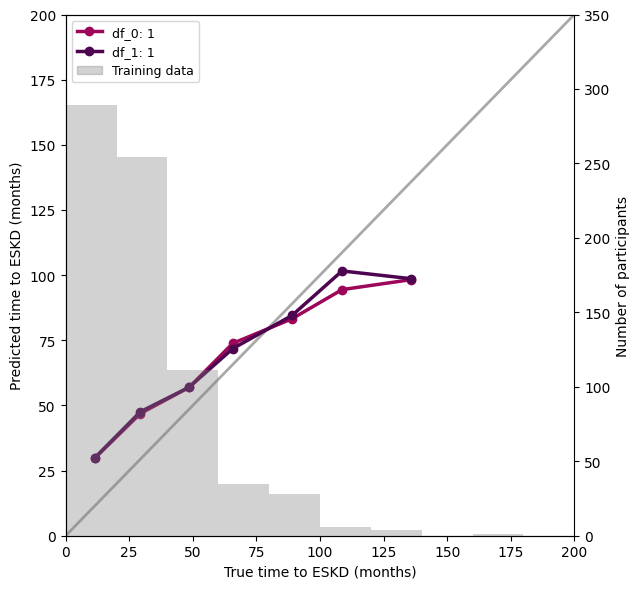


df_0:
Accuracy of censored cases predictions: 0.89 [np.float64(0.88), np.float64(0.89), np.float64(0.88), np.float64(0.93), np.float64(0.89)]
R^2: -1.05 [-1.03, -1.64, -1.19, -1.0, -0.38]
MAE: 22.38 [np.float64(21.0), np.float64(24.1), np.float64(21.8), np.float64(23.3), np.float64(21.7)]
C index: 0.87 [np.float64(0.865), np.float64(0.853), np.float64(0.866), np.float64(0.879), np.float64(0.874)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.88 [np.float64(0.87), np.float64(0.88), np.float64(0.88), np.float64(0.9), np.float64(0.89)]
R^2: -1.06 [-1.18, -1.39, -1.01, -1.07, -0.63]
MAE: 22.4 [np.float64(21.6), np.float64(23.4), np.float64(21.3), np.float64(23.0), np.float64(22.7)]
C index: 0.87 [np.float64(0.867), np.float64(0.856), np.float64(0.866), np.float64(0.877), np.float64(0.866)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric': 'a

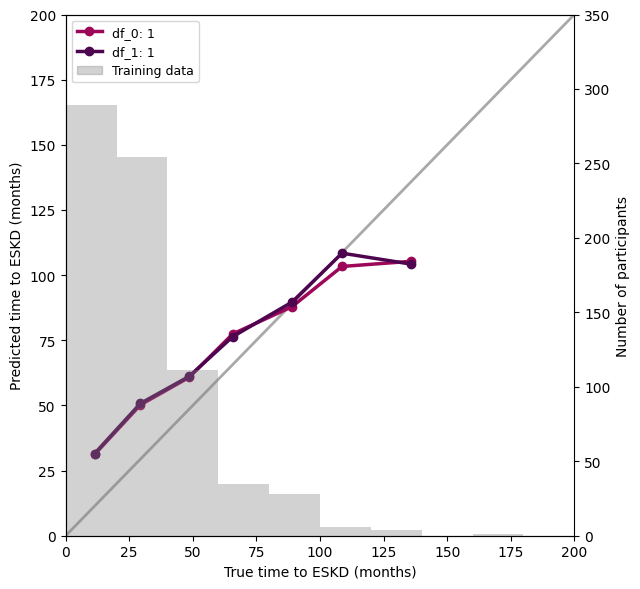


df_0:
Accuracy of censored cases predictions: 0.91 [np.float64(0.9), np.float64(0.9), np.float64(0.9), np.float64(0.94), np.float64(0.91)]
R^2: -1.38 [-1.54, -2.03, -1.46, -1.23, -0.62]
MAE: 24.28 [np.float64(23.8), np.float64(25.8), np.float64(23.2), np.float64(25.2), np.float64(23.4)]
C index: 0.87 [np.float64(0.862), np.float64(0.852), np.float64(0.868), np.float64(0.878), np.float64(0.875)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.9 [np.float64(0.89), np.float64(0.9), np.float64(0.9), np.float64(0.92), np.float64(0.91)]
R^2: -1.49 [-1.58, -1.84, -1.47, -1.62, -0.94]
MAE: 24.6 [np.float64(23.8), np.float64(25.4), np.float64(23.6), np.float64(25.6), np.float64(24.6)]
C index: 0.87 [np.float64(0.867), np.float64(0.857), np.float64(0.865), np.float64(0.877), np.float64(0.868)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric': 'aft-n

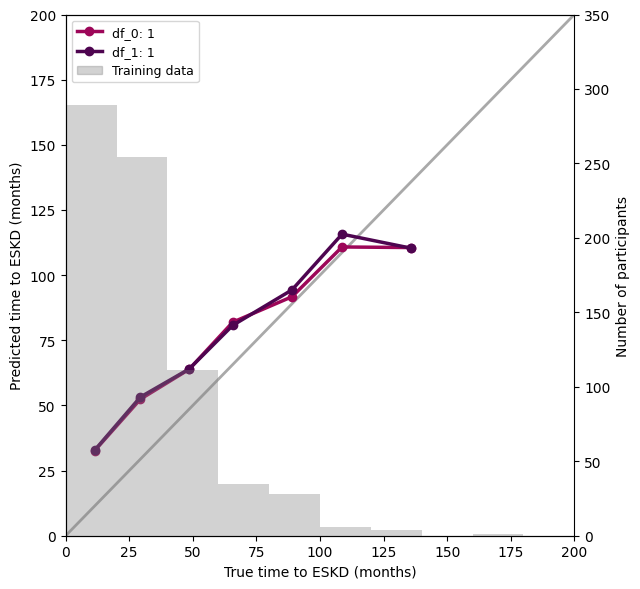


df_0:
Accuracy of censored cases predictions: 0.92 [np.float64(0.91), np.float64(0.91), np.float64(0.91), np.float64(0.94), np.float64(0.92)]
R^2: -1.76 [-2.04, -2.39, -1.79, -1.72, -0.87]
MAE: 26.08 [np.float64(25.8), np.float64(27.6), np.float64(24.7), np.float64(27.3), np.float64(25.0)]
C index: 0.87 [np.float64(0.864), np.float64(0.854), np.float64(0.866), np.float64(0.876), np.float64(0.874)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.92 [np.float64(0.91), np.float64(0.91), np.float64(0.91), np.float64(0.94), np.float64(0.92)]
R^2: -1.79 [-2.02, -2.31, -1.65, -1.68, -1.27]
MAE: 26.14 [np.float64(25.8), np.float64(27.3), np.float64(24.6), np.float64(26.3), np.float64(26.7)]
C index: 0.87 [np.float64(0.865), np.float64(0.857), np.float64(0.867), np.float64(0.88), np.float64(0.866)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric': 

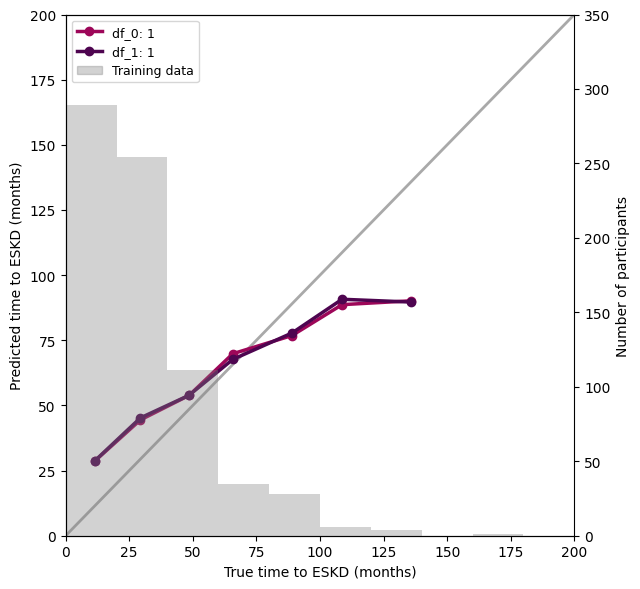


df_0:
Accuracy of censored cases predictions: 0.87 [np.float64(0.85), np.float64(0.87), np.float64(0.85), np.float64(0.9), np.float64(0.87)]
R^2: -0.62 [-0.72, -1.01, -0.73, -0.47, -0.16]
MAE: 20.58 [np.float64(19.9), np.float64(21.6), np.float64(20.0), np.float64(21.0), np.float64(20.4)]
C index: 0.87 [np.float64(0.864), np.float64(0.852), np.float64(0.865), np.float64(0.88), np.float64(0.872)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.86 [np.float64(0.85), np.float64(0.86), np.float64(0.86), np.float64(0.88), np.float64(0.87)]
R^2: -0.62 [-0.68, -0.89, -0.61, -0.58, -0.36]
MAE: 20.56 [np.float64(20.0), np.float64(21.2), np.float64(19.3), np.float64(21.1), np.float64(21.2)]
C index: 0.87 [np.float64(0.864), np.float64(0.856), np.float64(0.867), np.float64(0.877), np.float64(0.865)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric': '

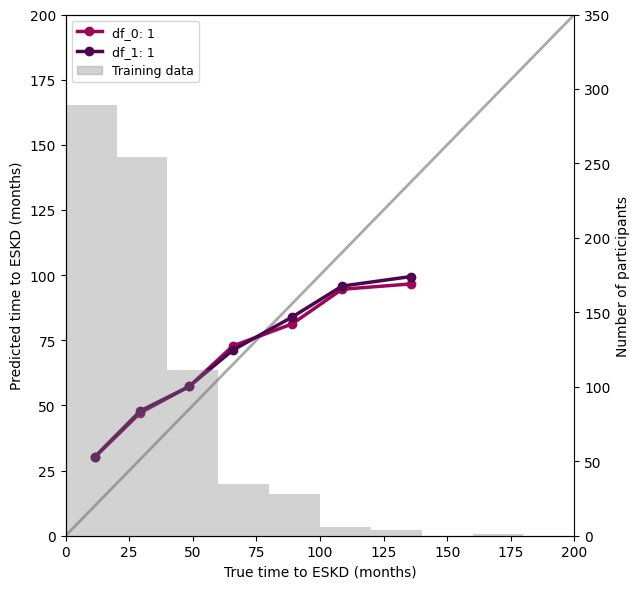


df_0:
Accuracy of censored cases predictions: 0.89 [np.float64(0.88), np.float64(0.89), np.float64(0.88), np.float64(0.92), np.float64(0.88)]
R^2: -0.91 [-1.01, -1.37, -1.03, -0.81, -0.35]
MAE: 22.26 [np.float64(21.3), np.float64(23.3), np.float64(21.6), np.float64(23.4), np.float64(21.7)]
C index: 0.87 [np.float64(0.863), np.float64(0.851), np.float64(0.865), np.float64(0.876), np.float64(0.872)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.89 [np.float64(0.88), np.float64(0.89), np.float64(0.89), np.float64(0.91), np.float64(0.89)]
R^2: -0.94 [-1.03, -1.26, -0.86, -0.91, -0.64]
MAE: 22.34 [np.float64(21.7), np.float64(23.2), np.float64(21.0), np.float64(22.9), np.float64(22.9)]
C index: 0.87 [np.float64(0.864), np.float64(0.856), np.float64(0.868), np.float64(0.878), np.float64(0.866)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric':

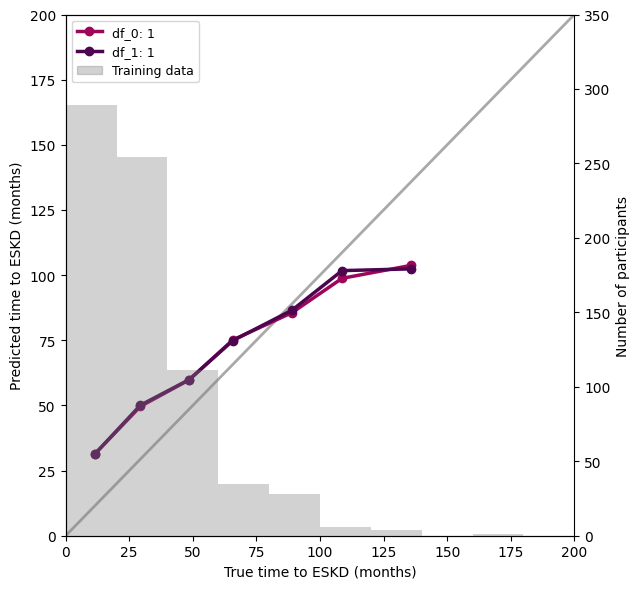


df_0:
Accuracy of censored cases predictions: 0.9 [np.float64(0.89), np.float64(0.89), np.float64(0.89), np.float64(0.93), np.float64(0.91)]
R^2: -1.2 [-1.4, -1.72, -1.26, -1.07, -0.55]
MAE: 23.7 [np.float64(23.1), np.float64(24.9), np.float64(22.7), np.float64(24.6), np.float64(23.2)]
C index: 0.87 [np.float64(0.863), np.float64(0.852), np.float64(0.867), np.float64(0.875), np.float64(0.873)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.9 [np.float64(0.89), np.float64(0.89), np.float64(0.9), np.float64(0.93), np.float64(0.91)]
R^2: -1.17 [-1.38, -1.52, -1.07, -1.08, -0.82]
MAE: 23.66 [np.float64(23.3), np.float64(24.5), np.float64(22.1), np.float64(24.1), np.float64(24.3)]
C index: 0.87 [np.float64(0.864), np.float64(0.856), np.float64(0.867), np.float64(0.878), np.float64(0.867)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric': 'aft-

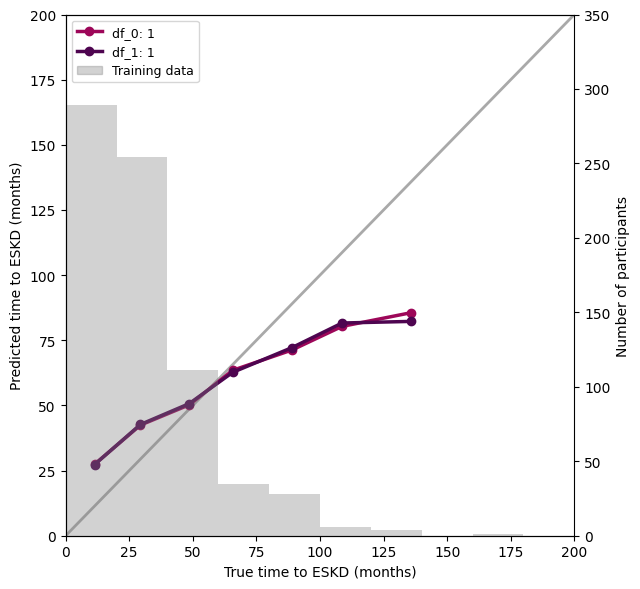


df_0:
Accuracy of censored cases predictions: 0.84 [np.float64(0.83), np.float64(0.84), np.float64(0.84), np.float64(0.87), np.float64(0.84)]
R^2: -0.32 [-0.34, -0.66, -0.43, -0.22, 0.04]
MAE: 19.06 [np.float64(17.7), np.float64(20.1), np.float64(18.7), np.float64(19.7), np.float64(19.1)]
C index: 0.87 [np.float64(0.866), np.float64(0.848), np.float64(0.865), np.float64(0.876), np.float64(0.873)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.84 [np.float64(0.82), np.float64(0.84), np.float64(0.84), np.float64(0.86), np.float64(0.84)]
R^2: -0.32 [-0.34, -0.48, -0.36, -0.27, -0.14]
MAE: 18.78 [np.float64(17.8), np.float64(19.1), np.float64(18.1), np.float64(19.3), np.float64(19.6)]
C index: 0.87 [np.float64(0.866), np.float64(0.856), np.float64(0.87), np.float64(0.876), np.float64(0.863)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric': '

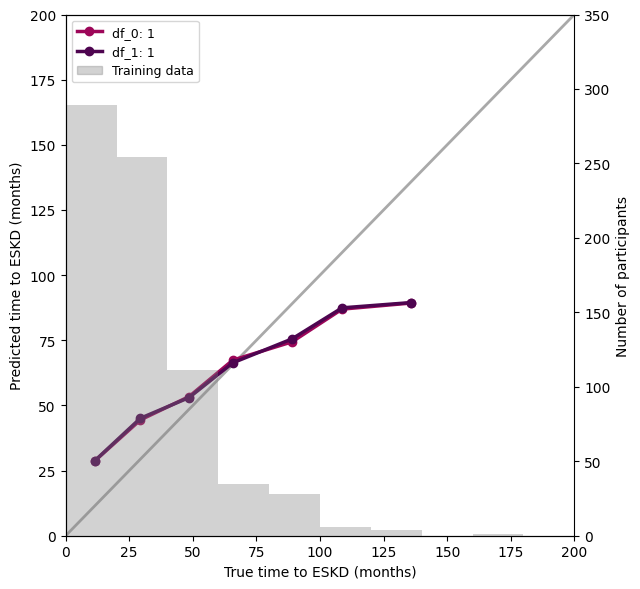


df_0:
Accuracy of censored cases predictions: 0.87 [np.float64(0.86), np.float64(0.87), np.float64(0.86), np.float64(0.91), np.float64(0.86)]
R^2: -0.52 [-0.57, -0.86, -0.64, -0.42, -0.11]
MAE: 20.28 [np.float64(19.2), np.float64(21.1), np.float64(19.7), np.float64(21.3), np.float64(20.1)]
C index: 0.87 [np.float64(0.865), np.float64(0.852), np.float64(0.867), np.float64(0.876), np.float64(0.873)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.87 [np.float64(0.85), np.float64(0.86), np.float64(0.86), np.float64(0.89), np.float64(0.87)]
R^2: -0.52 [-0.55, -0.79, -0.53, -0.46, -0.28]
MAE: 20.16 [np.float64(19.3), np.float64(20.9), np.float64(19.1), np.float64(20.7), np.float64(20.8)]
C index: 0.87 [np.float64(0.866), np.float64(0.855), np.float64(0.867), np.float64(0.876), np.float64(0.865)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric':

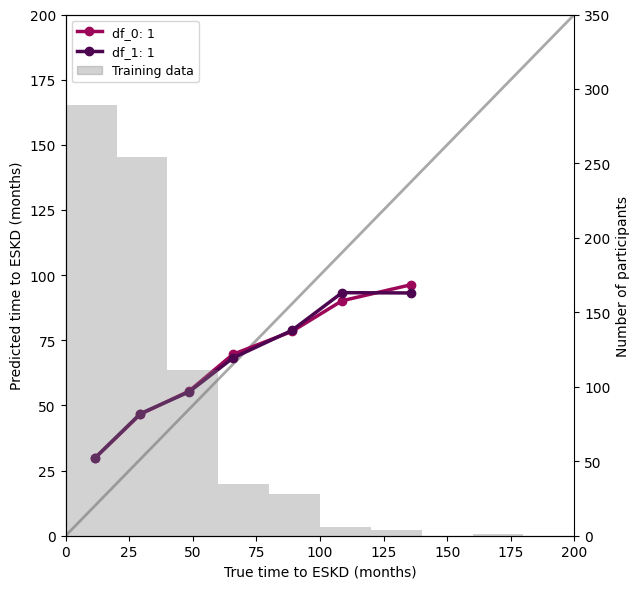


df_0:
Accuracy of censored cases predictions: 0.88 [np.float64(0.86), np.float64(0.88), np.float64(0.87), np.float64(0.92), np.float64(0.88)]
R^2: -0.72 [-0.84, -1.09, -0.79, -0.63, -0.23]
MAE: 21.36 [np.float64(20.6), np.float64(22.3), np.float64(20.6), np.float64(22.3), np.float64(21.0)]
C index: 0.86 [np.float64(0.864), np.float64(0.85), np.float64(0.865), np.float64(0.875), np.float64(0.871)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.88 [np.float64(0.86), np.float64(0.87), np.float64(0.86), np.float64(0.91), np.float64(0.88)]
R^2: -0.7 [-0.8, -0.98, -0.68, -0.6, -0.43]
MAE: 21.22 [np.float64(20.9), np.float64(22.0), np.float64(20.0), np.float64(21.5), np.float64(21.7)]
C index: 0.87 [np.float64(0.865), np.float64(0.854), np.float64(0.866), np.float64(0.877), np.float64(0.866)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric': 'af

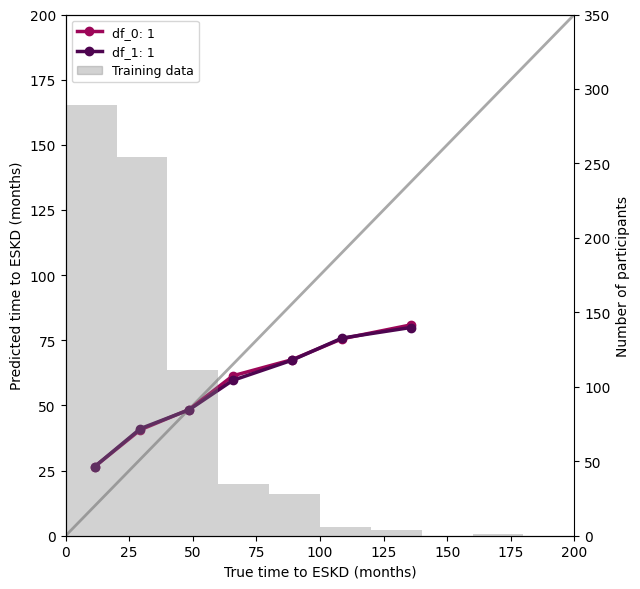


df_0:
Accuracy of censored cases predictions: 0.82 [np.float64(0.81), np.float64(0.82), np.float64(0.8), np.float64(0.85), np.float64(0.81)]
R^2: -0.15 [-0.2, -0.4, -0.3, -0.02, 0.16]
MAE: 18.1 [np.float64(17.1), np.float64(18.9), np.float64(18.0), np.float64(18.5), np.float64(18.0)]
C index: 0.86 [np.float64(0.862), np.float64(0.849), np.float64(0.866), np.float64(0.875), np.float64(0.871)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.81 [np.float64(0.8), np.float64(0.81), np.float64(0.8), np.float64(0.84), np.float64(0.81)]
R^2: -0.14 [-0.17, -0.28, -0.19, -0.1, 0.05]
MAE: 17.8 [np.float64(17.0), np.float64(18.2), np.float64(17.2), np.float64(18.4), np.float64(18.2)]
C index: 0.86 [np.float64(0.864), np.float64(0.852), np.float64(0.869), np.float64(0.873), np.float64(0.865)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric': 'aft-nlogl

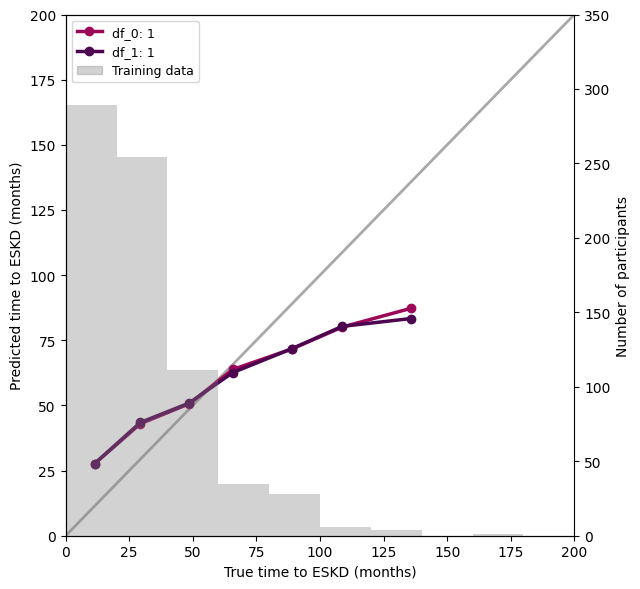


df_0:
Accuracy of censored cases predictions: 0.84 [np.float64(0.82), np.float64(0.84), np.float64(0.82), np.float64(0.88), np.float64(0.84)]
R^2: -0.28 [-0.33, -0.52, -0.44, -0.14, 0.03]
MAE: 19.02 [np.float64(18.1), np.float64(19.6), np.float64(18.5), np.float64(19.6), np.float64(19.3)]
C index: 0.86 [np.float64(0.862), np.float64(0.85), np.float64(0.863), np.float64(0.877), np.float64(0.871)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.84 [np.float64(0.83), np.float64(0.85), np.float64(0.83), np.float64(0.87), np.float64(0.84)]
R^2: -0.3 [-0.34, -0.48, -0.32, -0.26, -0.1]
MAE: 18.98 [np.float64(18.4), np.float64(19.5), np.float64(18.0), np.float64(19.5), np.float64(19.5)]
C index: 0.86 [np.float64(0.863), np.float64(0.852), np.float64(0.869), np.float64(0.874), np.float64(0.865)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric': 'af

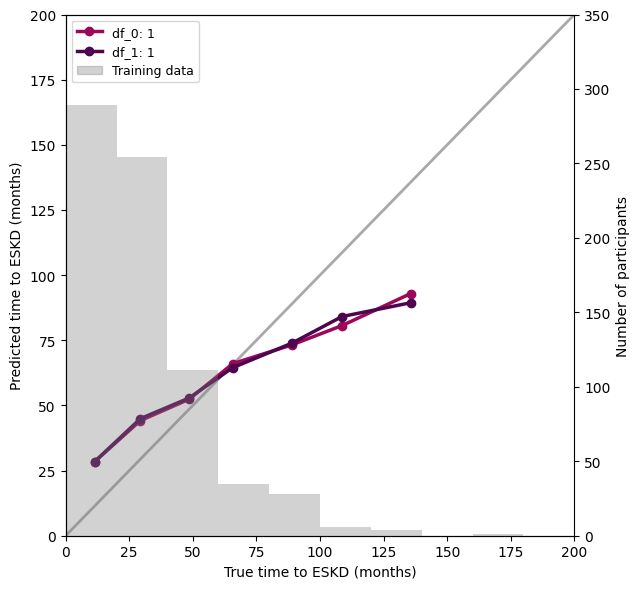


df_0:
Accuracy of censored cases predictions: 0.85 [np.float64(0.84), np.float64(0.85), np.float64(0.85), np.float64(0.88), np.float64(0.85)]
R^2: -0.38 [-0.48, -0.66, -0.52, -0.24, -0.01]
MAE: 19.64 [np.float64(19.1), np.float64(20.4), np.float64(19.1), np.float64(20.2), np.float64(19.4)]
C index: 0.87 [np.float64(0.863), np.float64(0.85), np.float64(0.866), np.float64(0.874), np.float64(0.873)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.86 [np.float64(0.84), np.float64(0.86), np.float64(0.85), np.float64(0.88), np.float64(0.86)]
R^2: -0.4 [-0.52, -0.57, -0.4, -0.3, -0.19]
MAE: 19.62 [np.float64(19.6), np.float64(20.1), np.float64(18.4), np.float64(19.9), np.float64(20.1)]
C index: 0.87 [np.float64(0.862), np.float64(0.855), np.float64(0.869), np.float64(0.877), np.float64(0.866)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric': 'af

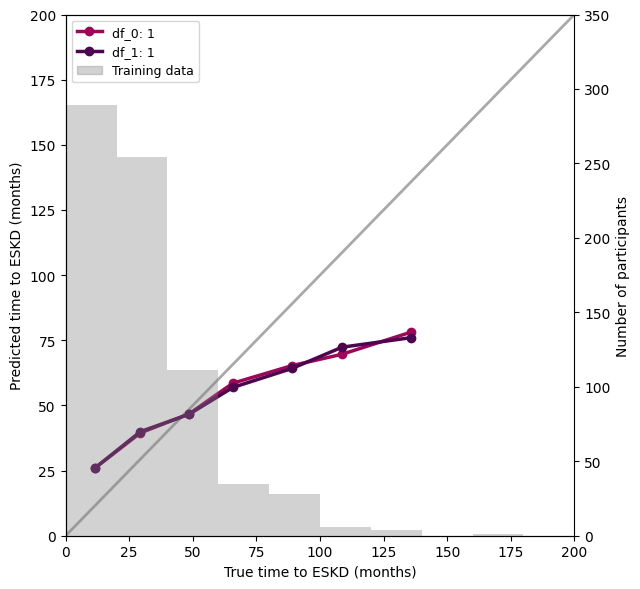


df_0:
Accuracy of censored cases predictions: 0.79 [np.float64(0.77), np.float64(0.79), np.float64(0.79), np.float64(0.83), np.float64(0.79)]
R^2: -0.04 [-0.08, -0.23, -0.17, 0.09, 0.2]
MAE: 17.2 [np.float64(16.2), np.float64(17.8), np.float64(17.2), np.float64(17.5), np.float64(17.3)]
C index: 0.86 [np.float64(0.862), np.float64(0.847), np.float64(0.866), np.float64(0.877), np.float64(0.87)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.79 [np.float64(0.77), np.float64(0.8), np.float64(0.77), np.float64(0.82), np.float64(0.8)]
R^2: -0.04 [-0.02, -0.18, -0.1, 0.01, 0.07]
MAE: 17.2 [np.float64(15.9), np.float64(17.6), np.float64(16.9), np.float64(17.5), np.float64(18.1)]
C index: 0.86 [np.float64(0.865), np.float64(0.853), np.float64(0.87), np.float64(0.872), np.float64(0.863)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric': 'aft-nlogli

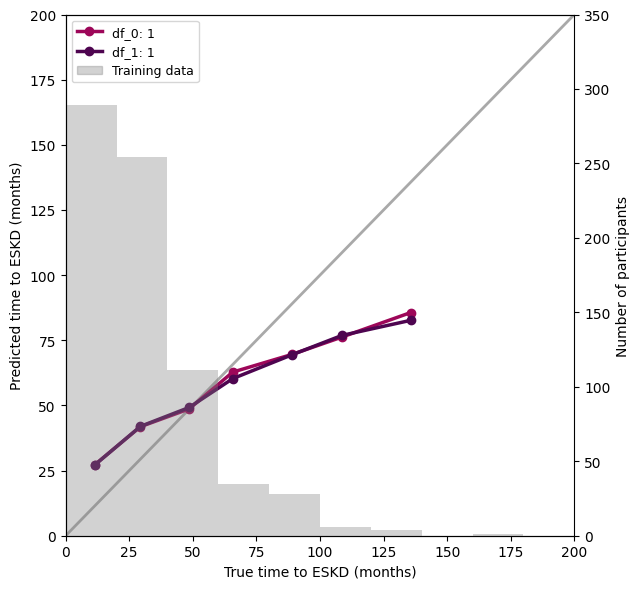


df_0:
Accuracy of censored cases predictions: 0.83 [np.float64(0.82), np.float64(0.82), np.float64(0.81), np.float64(0.86), np.float64(0.83)]
R^2: -0.19 [-0.27, -0.39, -0.33, -0.05, 0.1]
MAE: 18.42 [np.float64(17.7), np.float64(18.9), np.float64(18.1), np.float64(18.9), np.float64(18.5)]
C index: 0.86 [np.float64(0.861), np.float64(0.848), np.float64(0.863), np.float64(0.877), np.float64(0.87)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.82 [np.float64(0.82), np.float64(0.82), np.float64(0.81), np.float64(0.84), np.float64(0.82)]
R^2: -0.17 [-0.23, -0.34, -0.2, -0.07, -0.01]
MAE: 18.1 [np.float64(17.6), np.float64(18.7), np.float64(17.3), np.float64(18.4), np.float64(18.5)]
C index: 0.86 [np.float64(0.863), np.float64(0.851), np.float64(0.87), np.float64(0.875), np.float64(0.864)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric': 'aft-

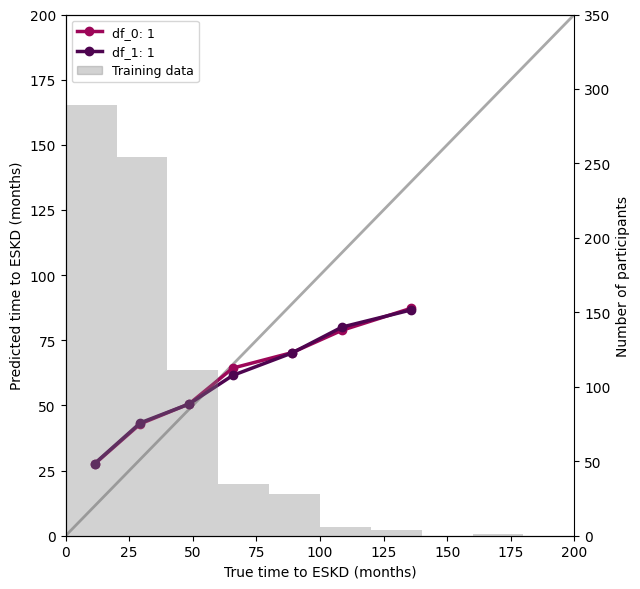


df_0:
Accuracy of censored cases predictions: 0.84 [np.float64(0.83), np.float64(0.84), np.float64(0.83), np.float64(0.87), np.float64(0.83)]
R^2: -0.27 [-0.33, -0.55, -0.35, -0.15, 0.05]
MAE: 18.9 [np.float64(18.2), np.float64(19.6), np.float64(18.2), np.float64(19.6), np.float64(18.9)]
C index: 0.86 [np.float64(0.863), np.float64(0.849), np.float64(0.866), np.float64(0.875), np.float64(0.871)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.84 [np.float64(0.83), np.float64(0.83), np.float64(0.83), np.float64(0.86), np.float64(0.85)]
R^2: -0.26 [-0.33, -0.42, -0.29, -0.16, -0.09]
MAE: 18.72 [np.float64(18.4), np.float64(19.1), np.float64(17.8), np.float64(19.1), np.float64(19.2)]
C index: 0.86 [np.float64(0.863), np.float64(0.854), np.float64(0.868), np.float64(0.874), np.float64(0.865)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric': '

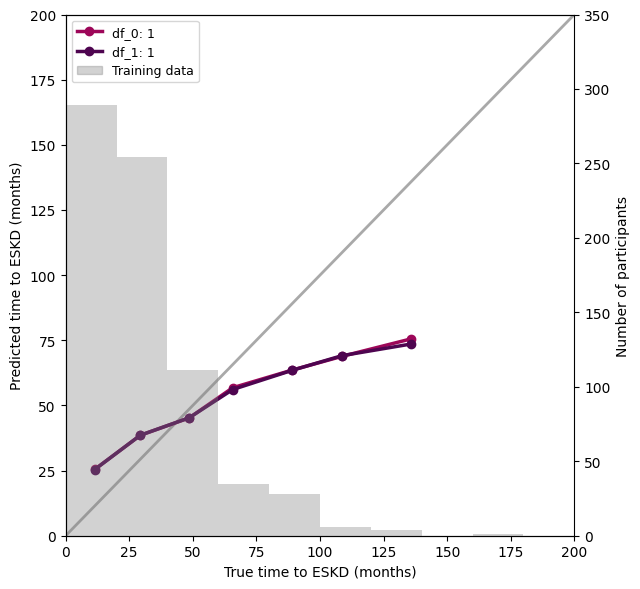


df_0:
Accuracy of censored cases predictions: 0.78 [np.float64(0.76), np.float64(0.77), np.float64(0.77), np.float64(0.82), np.float64(0.78)]
R^2: 0.03 [0.02, -0.13, -0.1, 0.13, 0.23]
MAE: 16.78 [np.float64(15.4), np.float64(17.3), np.float64(16.9), np.float64(17.2), np.float64(17.1)]
C index: 0.86 [np.float64(0.861), np.float64(0.846), np.float64(0.865), np.float64(0.875), np.float64(0.869)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.78 [np.float64(0.76), np.float64(0.78), np.float64(0.76), np.float64(0.8), np.float64(0.79)]
R^2: 0.03 [0.03, -0.08, -0.03, 0.08, 0.14]
MAE: 16.64 [np.float64(15.4), np.float64(16.8), np.float64(16.4), np.float64(17.2), np.float64(17.4)]
C index: 0.86 [np.float64(0.865), np.float64(0.852), np.float64(0.87), np.float64(0.872), np.float64(0.863)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric': 'aft-nlogl

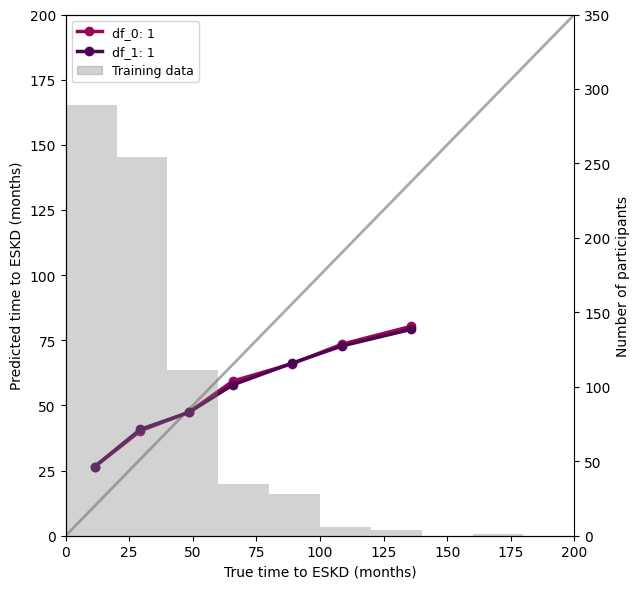


df_0:
Accuracy of censored cases predictions: 0.8 [np.float64(0.78), np.float64(0.81), np.float64(0.79), np.float64(0.84), np.float64(0.8)]
R^2: -0.1 [-0.17, -0.32, -0.19, 0.04, 0.16]
MAE: 17.74 [np.float64(16.9), np.float64(18.5), np.float64(17.5), np.float64(18.0), np.float64(17.8)]
C index: 0.86 [np.float64(0.86), np.float64(0.846), np.float64(0.865), np.float64(0.876), np.float64(0.871)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.8 [np.float64(0.78), np.float64(0.81), np.float64(0.78), np.float64(0.83), np.float64(0.81)]
R^2: -0.08 [-0.09, -0.21, -0.14, -0.01, 0.05]
MAE: 17.44 [np.float64(16.4), np.float64(17.8), np.float64(17.0), np.float64(17.8), np.float64(18.2)]
C index: 0.86 [np.float64(0.865), np.float64(0.853), np.float64(0.868), np.float64(0.875), np.float64(0.864)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric': 'aft-nl

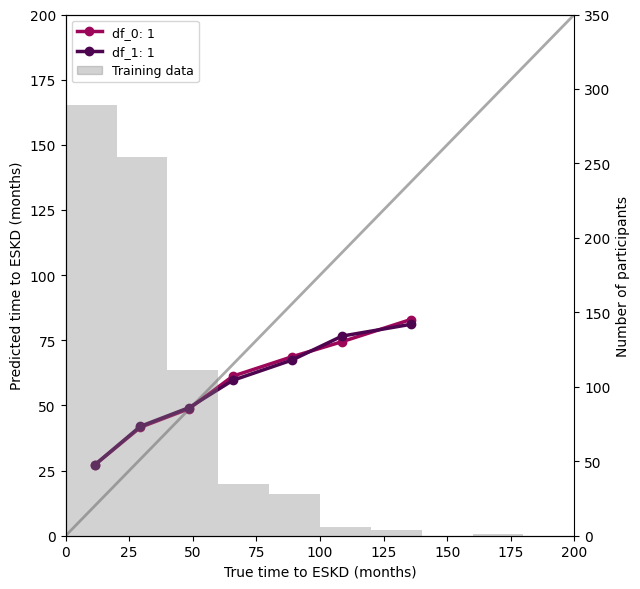


df_0:
Accuracy of censored cases predictions: 0.82 [np.float64(0.81), np.float64(0.82), np.float64(0.81), np.float64(0.86), np.float64(0.81)]
R^2: -0.17 [-0.2, -0.43, -0.26, -0.06, 0.12]
MAE: 18.12 [np.float64(17.1), np.float64(19.0), np.float64(17.6), np.float64(18.6), np.float64(18.3)]
C index: 0.86 [np.float64(0.864), np.float64(0.847), np.float64(0.864), np.float64(0.874), np.float64(0.87)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.82 [np.float64(0.81), np.float64(0.82), np.float64(0.81), np.float64(0.84), np.float64(0.82)]
R^2: -0.16 [-0.21, -0.33, -0.17, -0.08, -0.02]
MAE: 18.04 [np.float64(17.5), np.float64(18.5), np.float64(17.2), np.float64(18.3), np.float64(18.7)]
C index: 0.86 [np.float64(0.863), np.float64(0.853), np.float64(0.869), np.float64(0.875), np.float64(0.864)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 'survival:aft', 'eval_metric': 'a

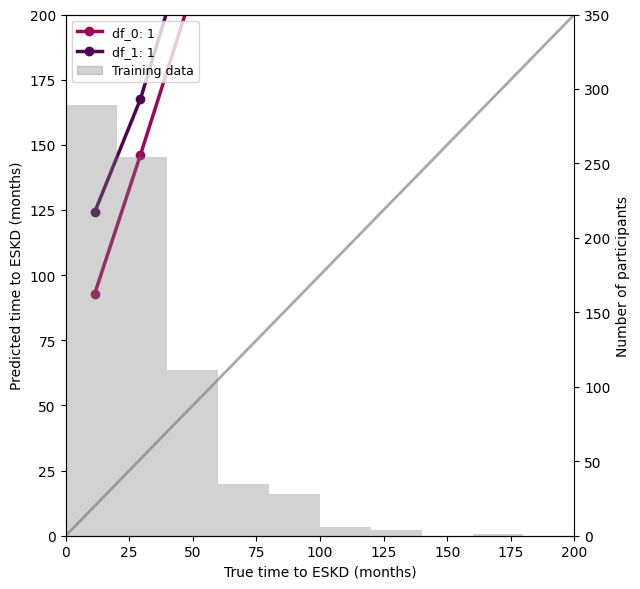


df_0:
Accuracy of censored cases predictions: 0.98 [np.float64(0.98), np.float64(0.97), np.float64(0.99), np.float64(0.99), np.float64(0.99)]
R^2: -140.1 [-47.65, -93.51, -268.41, -240.41, -50.5]
MAE: 122.46 [np.float64(88.8), np.float64(126.0), np.float64(149.2), np.float64(141.4), np.float64(106.9)]
C index: 0.84 [np.float64(0.839), np.float64(0.825), np.float64(0.836), np.float64(0.859), np.float64(0.842)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.98 [np.float64(0.98), np.float64(0.97), np.float64(0.98), np.float64(0.99), np.float64(0.98)]
R^2: -188.58 [-80.69, -288.47, -280.97, -198.46, -94.33]
MAE: 155.62 [np.float64(114.2), np.float64(191.3), np.float64(168.3), np.float64(157.9), np.float64(146.4)]
C index: 0.82 [np.float64(0.823), np.float64(0.817), np.float64(0.816), np.float64(0.853), np.float64(0.809)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objective': 's

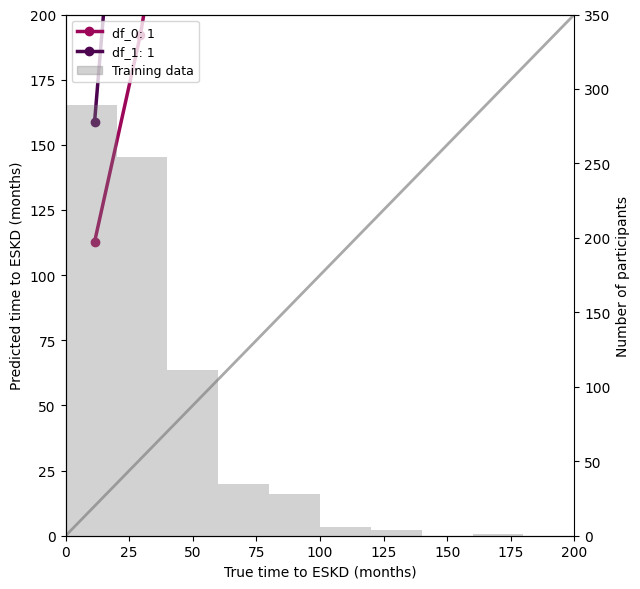


df_0:
Accuracy of censored cases predictions: 0.98 [np.float64(0.98), np.float64(0.97), np.float64(0.99), np.float64(0.99), np.float64(0.99)]
R^2: -258.2 [-234.86, -328.15, -183.44, -384.7, -159.87]
MAE: 166.82 [np.float64(139.3), np.float64(192.2), np.float64(167.7), np.float64(190.2), np.float64(144.7)]
C index: 0.83 [np.float64(0.856), np.float64(0.828), np.float64(0.811), np.float64(0.842), np.float64(0.835)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.99 [np.float64(0.98), np.float64(0.99), np.float64(0.99), np.float64(0.99), np.float64(0.99)]
R^2: -1896.83 [-258.39, -296.4, -326.14, -318.64, -8284.57]
MAE: 261.38 [np.float64(179.6), np.float64(213.4), np.float64(202.5), np.float64(227.8), np.float64(483.6)]
C index: 0.83 [np.float64(0.84), np.float64(0.829), np.float64(0.817), np.float64(0.833), np.float64(0.816)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objectiv

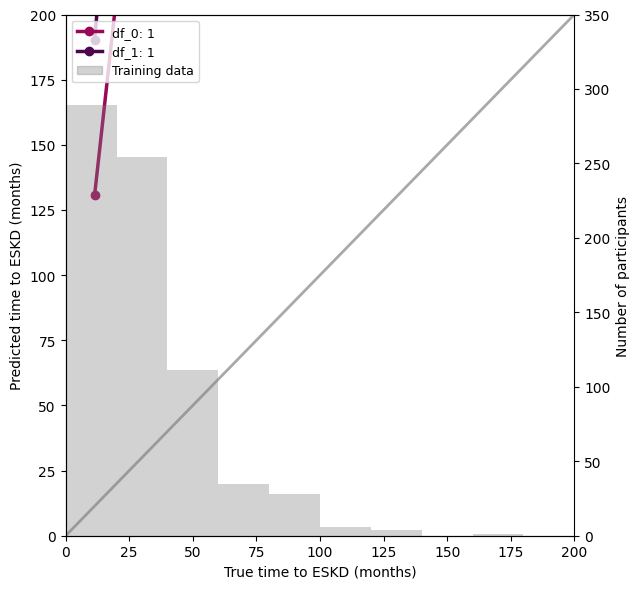


df_0:
Accuracy of censored cases predictions: 0.99 [np.float64(0.99), np.float64(0.99), np.float64(0.99), np.float64(0.99), np.float64(0.99)]
R^2: -680.81 [-262.42, -1124.79, -407.97, -1220.64, -388.23]
MAE: 251.28 [np.float64(172.6), np.float64(280.4), np.float64(206.6), np.float64(372.2), np.float64(224.6)]
C index: 0.83 [np.float64(0.845), np.float64(0.825), np.float64(0.816), np.float64(0.831), np.float64(0.829)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.99 [np.float64(0.98), np.float64(0.99), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R^2: -2198.34 [-700.55, -7740.12, -691.72, -973.48, -885.82]
MAE: 340.62 [np.float64(290.1), np.float64(478.6), np.float64(276.9), np.float64(326.5), np.float64(331.0)]
C index: 0.82 [np.float64(0.816), np.float64(0.827), np.float64(0.808), np.float64(0.854), np.float64(0.814)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'objec

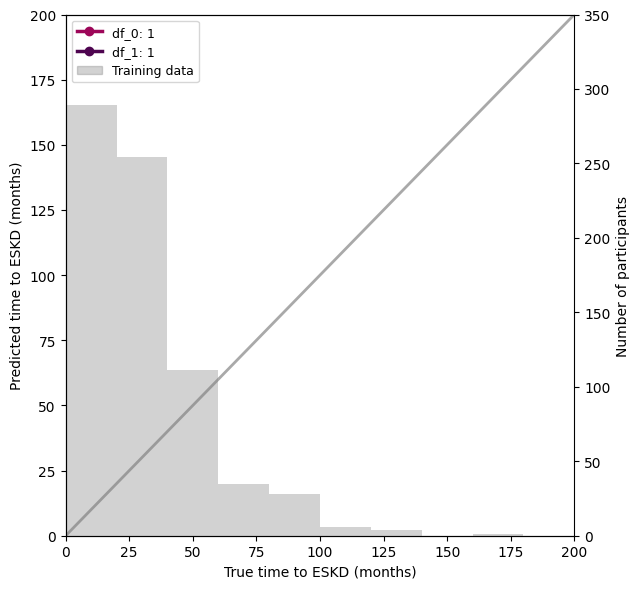


df_0:
Accuracy of censored cases predictions: 0.99 [np.float64(0.99), np.float64(0.98), np.float64(0.99), np.float64(0.99), np.float64(1.0)]
R^2: -7799485611032.79 [-13515574.98, -38436865391590.49, -492214911962.03, -762610398.8, -67571625637.67]
MAE: 3669938.7 [np.float64(9950.5), np.float64(15683900.1), np.float64(1571729.2), np.float64(110237.1), np.float64(973876.6)]
C index: 0.79 [np.float64(0.797), np.float64(0.805), np.float64(0.767), np.float64(0.803), np.float64(0.759)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.99 [np.float64(0.99), np.float64(0.99), np.float64(0.99), np.float64(1.0), np.float64(1.0)]
R^2: -92322653443167.6 [-1988013776027.97, -2924486120.94, -1972041031916.74, -3453881433537.19, -454196406488235.1]
MAE: 12237578.12 [np.float64(4087915.5), np.float64(285830.0), np.float64(4857160.6), np.float64(5855152.5), np.float64(46101832.0)]
C index: 0.77 [np.float64(0.757), np.float64(0.

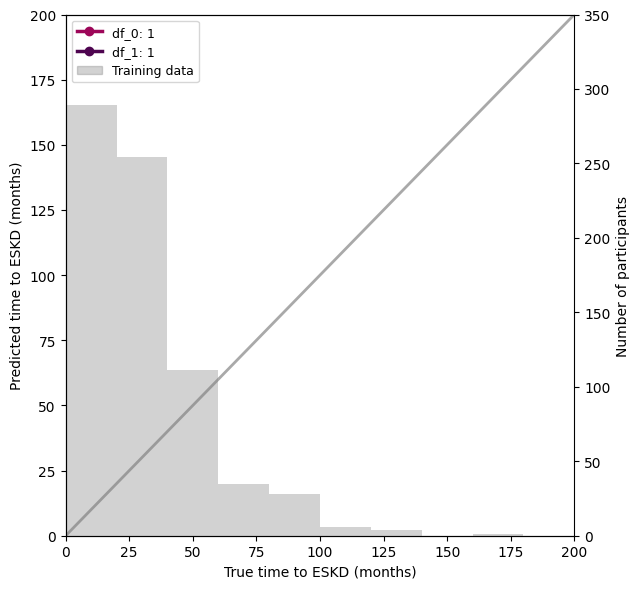


df_0:
Accuracy of censored cases predictions: 1.0 [np.float64(0.99), np.float64(0.99), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R^2: -3.750302749937557e+23 [-9016118444619.31, -4.552091073661601e+23, -1.4196843168021476e+24, -94367438399985.27, -2.5795069708726164e+20]
MAE: 731559634698.7 [np.float64(6569693.2), np.float64(1369847219870.0), np.float64(2253222282830.3), np.float64(21154416.3), np.float64(34700946683.7)]
C index: 0.78 [np.float64(0.768), np.float64(0.775), np.float64(0.766), np.float64(0.801), np.float64(0.791)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 1.0 [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R^2: -7.373251986183232e+21 [-18629128465600.09, -16735297374293.9, -8.234095795142323e+20, -10492913646882.08, -3.604285030554459e+22]
MAE: 92869971080.84 [np.float64(8235910.2), np.float64(12564885.8), np.float64(74856907390.8), np.float64(8

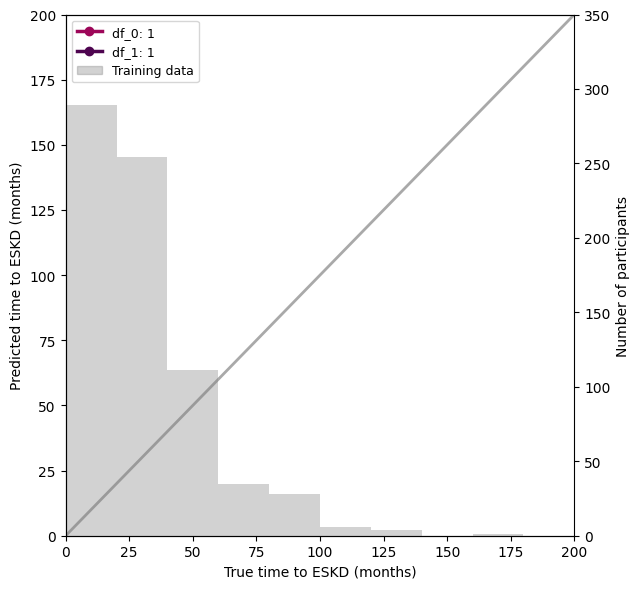


df_0:
Accuracy of censored cases predictions: 1.0 [np.float64(1.0), np.float64(0.99), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R^2: -1.1751833355250206e+16 [-5644646117437.89, -14474758197.94, -5.824778745298017e+16, -503242376986643.6, -2477825408602.15]
MAE: 118640901.02 [np.float64(6881451.5), np.float64(686680.2), np.float64(523160984.9), np.float64(56066479.2), np.float64(6408909.3)]
C index: 0.8 [np.float64(0.819), np.float64(0.818), np.float64(0.774), np.float64(0.82), np.float64(0.779)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 1.0 [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R^2: -1.641856198860121e+18 [-6.736155410687859e+17, -6.225137650030601e+18, -1.310432081135672e+18, -80901656690753.23, -14820408855134.98]
MAE: 2474681113.06 [np.float64(1418645921.6), np.float64(8255310762.5), np.float64(2648381258.4), np.float64(38794734.2), np.float64(12

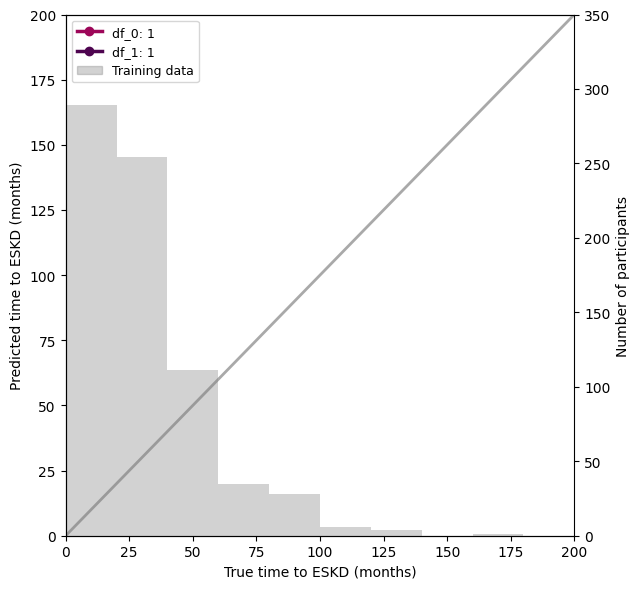


df_0:
Accuracy of censored cases predictions: 1.0 [np.float64(1.0), np.float64(0.99), np.float64(1.0), np.float64(0.99), np.float64(1.0)]
R^2: -2.9948296226875433e+18 [-1242227780335304.8, -2.5856509519123624e+16, -1.4944188717442398e+19, -2809870335472996.5, -50788360386826.98]
MAE: 2261618736.72 [np.float64(65765480.7), np.float64(314646109.1), np.float64(10779649235.8), np.float64(130232544.6), np.float64(17800313.4)]
C index: 0.78 [np.float64(0.792), np.float64(0.809), np.float64(0.766), np.float64(0.741), np.float64(0.769)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 1.0 [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R^2: -6.2262796364896246e+32 [-2.7887160401583613e+23, -9.394083364105941e+25, -1.6123678625442934e+18, -3.113139723998792e+33, -2.631362468627174e+22]
MAE: 3.358300681768265e+16 [np.float64(1263159506869.2), np.float64(20468192454471.7), np.float64(2

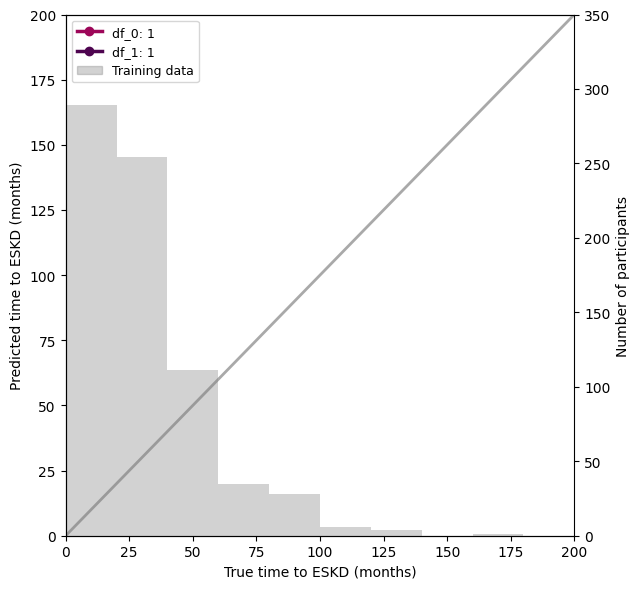


df_0:
Accuracy of censored cases predictions: 1.0 [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R^2: -1.0683063581942937e+25 [-1.9369691824926618e+18, -3.16293908310354e+16, -6.625715773898671e+20, -2.022648950901825e+20, -5.341445110464363e+25]
MAE: 2968323365985.1 [np.float64(2360703788.5), np.float64(394928800.2), np.float64(51540441210.6), np.float64(35602715892.2), np.float64(14751718040234.0)]
C index: 0.79 [np.float64(0.774), np.float64(0.799), np.float64(0.78), np.float64(0.802), np.float64(0.782)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 1.0 [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R^2: -1.1638739833529173e+34 [-1.1660143643222692e+16, -5.814804676745574e+34, -8.479540458072965e+22, -1.721083746473502e+18, -4.56524001053212e+31]
MAE: 9.653062738416906e+16 [np.float64(258127273.9), np.float64(4.6595863867066195e+

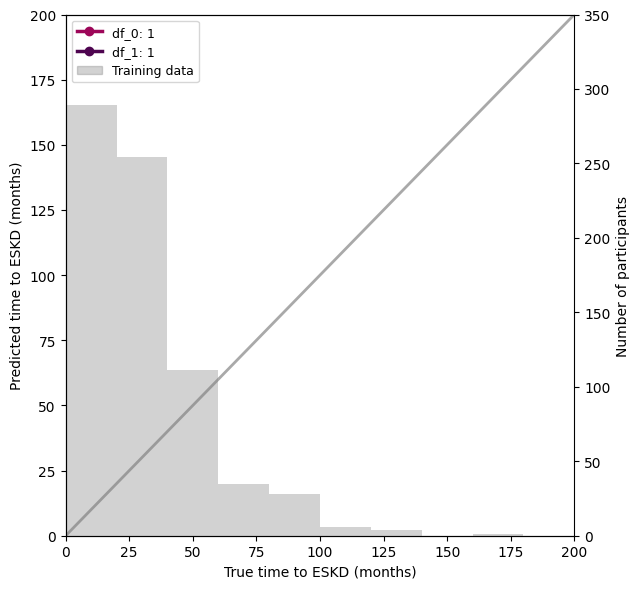


df_0:
Accuracy of censored cases predictions: 1.0 [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R^2: -4.716333279291724e+29 [-2.853991633149543e+18, -4.3442161556588897e+24, -2.3581622929676653e+30, -9.068104955102284e+18, -2.450119330393298e+21]
MAE: 598535267745232.8 [np.float64(4531707642.5), np.float64(4032570133789.2), np.float64(2988521118560537.5), np.float64(7147234085.2), np.float64(110971090109.8)]
C index: 0.78 [np.float64(0.825), np.float64(0.794), np.float64(0.714), np.float64(0.815), np.float64(0.777)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 1.0 [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
R^2: -5.861206027287155e+30 [-2.1104932655619898e+26, -1.3389714207318074e+24, -2.930581079762722e+31, -1.1735958368516327e+24, -5.776914736043602e+24]
MAE: 2959328471886302.5 [np.float64(24461853014742.8), np.float64(334860

In [10]:
calibrate = BaggingTimeCalibrate(n_splits=5,
                                 plot_lim=(0,200),
                                 verbose=True,
                                 early_stopping_rounds=150,
                                 num_boost_round=1500)
random_state = [1]
params = {'aft_loss_distribution': ['extreme', 'normal', 'logistic'],
          'aft_loss_distribution_scale': [0.125, 0.10, 0.075],
          'subset_fraction': [(1.0, 2.0), (1.0, 3.0), 1.0],
          'n_models': [50]
         }
calibration_results = calibrate.bagging_grid_search(dfs = [df_train_0, df_train_1],
                                                    params = params,
                                                    random_states = random_state,
                                                    labelcols = labelcols,
                                                    line_colors = ['xkcd:dark fuchsia', 'xkcd:plum purple', 'xkcd:medium pink'])

{'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'aft_loss_distribution': 'extreme', 'aft_loss_distribution_scale': 0.1, 'tree_method': 'hist', 'learning_rate': 0.01, 'max_depth': [8, 10], 'booster': 'gbtree', 'subsample': 1.0, 'min_child_weight': 1.0, 'colsample_bynode': 1.0, 'n_models': 30, 'subset_fraction': 1.0}
{'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'aft_loss_distribution': 'extreme', 'aft_loss_distribution_scale': 0.1, 'tree_method': 'hist', 'learning_rate': 0.01, 'max_depth': [8, 10], 'booster': 'gbtree', 'subsample': 1.0, 'min_child_weight': 1.0, 'colsample_bynode': 1.0, 'n_models': 50, 'subset_fraction': 1.0}


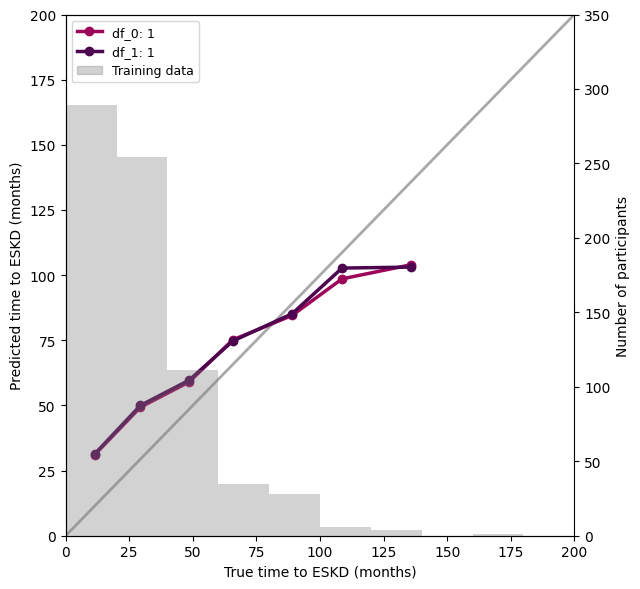


df_0:
Accuracy of censored cases predictions: 0.9 [np.float64(0.89), np.float64(0.9), np.float64(0.89), np.float64(0.93), np.float64(0.9)]
R^2: -1.14 [-1.26, -1.68, -1.24, -1.03, -0.47]
MAE: 23.38 [np.float64(22.6), np.float64(24.6), np.float64(22.7), np.float64(24.4), np.float64(22.6)]
C index: 0.87 [np.float64(0.864), np.float64(0.852), np.float64(0.863), np.float64(0.876), np.float64(0.874)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.9 [np.float64(0.89), np.float64(0.89), np.float64(0.89), np.float64(0.93), np.float64(0.9)]
R^2: -1.16 [-1.31, -1.48, -1.12, -1.1, -0.77]
MAE: 23.56 [np.float64(23.3), np.float64(24.3), np.float64(22.2), np.float64(24.1), np.float64(23.9)]
C index: 0.87 [np.float64(0.865), np.float64(0.856), np.float64(0.866), np.float64(0.878), np.float64(0.867)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [16]:
calibrate = BaggingTimeCalibrate(n_splits=5,
                                 plot_lim=(0,200),
                                 verbose=True,
                                 early_stopping_rounds=150,
                                 num_boost_round=1500)
random_state = [1]
params = {'aft_loss_distribution': ['extreme'],
          'aft_loss_distribution_scale': [0.1],
          'subset_fraction': [1.0],
          'n_models': [50]
         }
calibration_results = calibrate.bagging_grid_search(dfs = [df_train_0, df_train_1],
                                                    params = params,
                                                    random_states = random_state,
                                                    labelcols = labelcols,
                                                    line_colors = ['xkcd:dark fuchsia', 'xkcd:plum purple', 'xkcd:medium pink'])

{'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'aft_loss_distribution': 'extreme', 'aft_loss_distribution_scale': 0.1, 'tree_method': 'hist', 'learning_rate': 0.01, 'max_depth': [8, 10], 'booster': 'gbtree', 'subsample': 1.0, 'min_child_weight': 1.0, 'colsample_bynode': 1.0, 'n_models': 30, 'subset_fraction': 1.0}
{'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'aft_loss_distribution': 'extreme', 'aft_loss_distribution_scale': 0.1, 'tree_method': 'hist', 'learning_rate': 0.01, 'max_depth': [8, 10], 'booster': 'gbtree', 'subsample': 1.0, 'min_child_weight': 1.0, 'colsample_bynode': 1.0, 'n_models': 50, 'subset_fraction': 1.0}


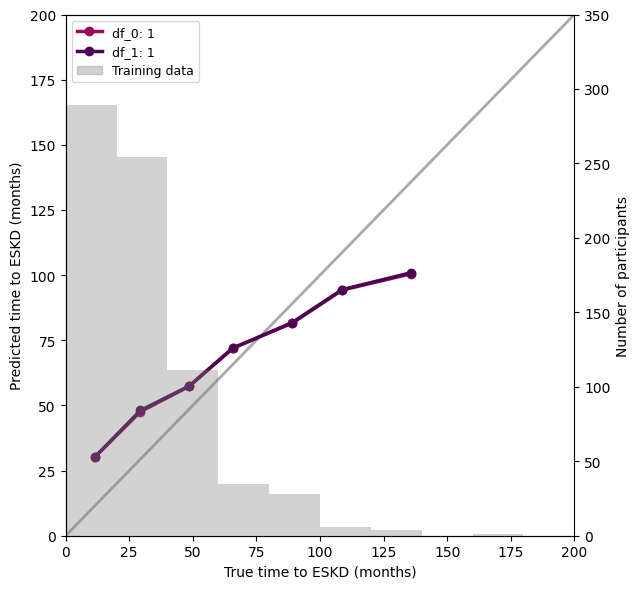


df_0:
Accuracy of censored cases predictions: 0.89 [np.float64(0.88), np.float64(0.89), np.float64(0.88), np.float64(0.93), np.float64(0.89)]
R^2: -0.94 [-1.09, -1.41, -0.98, -0.94, -0.3]
MAE: 22.34 [np.float64(21.7), np.float64(23.5), np.float64(21.3), np.float64(23.8), np.float64(21.4)]
C index: 0.87 [np.float64(0.864), np.float64(0.85), np.float64(0.866), np.float64(0.875), np.float64(0.875)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.89 [np.float64(0.88), np.float64(0.88), np.float64(0.89), np.float64(0.91), np.float64(0.89)]
R^2: -0.88 [-1.02, -1.22, -0.84, -0.74, -0.58]
MAE: 22.16 [np.float64(21.7), np.float64(23.1), np.float64(20.7), np.float64(22.6), np.float64(22.7)]
C index: 0.87 [np.float64(0.865), np.float64(0.856), np.float64(0.867), np.float64(0.878), np.float64(0.866)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [14]:
calibrate = BaggingTimeCalibrate(n_splits=5,
                                 plot_lim=(0,200),
                                 verbose=True,
                                 early_stopping_rounds=125,
                                 num_boost_round=1250)
random_state = [1]
params = {'aft_loss_distribution': ['extreme'],
          'aft_loss_distribution_scale': [0.1],
          'subset_fraction': [1.0],
          'n_models': [50]
         }
calibration_results = calibrate.bagging_grid_search(dfs = [df_train_0, df_train_1],
                                                    params = params,
                                                    random_states = random_state,
                                                    labelcols = labelcols,
                                                    line_colors = ['xkcd:dark fuchsia', 'xkcd:plum purple', 'xkcd:medium pink'])

{'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'aft_loss_distribution': 'extreme', 'aft_loss_distribution_scale': 0.1, 'tree_method': 'hist', 'learning_rate': 0.01, 'max_depth': [8, 10], 'booster': 'gbtree', 'subsample': 1.0, 'min_child_weight': 1.0, 'colsample_bynode': 1.0, 'n_models': 30, 'subset_fraction': 1.0}
{'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'aft_loss_distribution': 'extreme', 'aft_loss_distribution_scale': 0.1, 'tree_method': 'hist', 'learning_rate': 0.01, 'max_depth': [8, 10], 'booster': 'gbtree', 'subsample': 1.0, 'min_child_weight': 1.0, 'colsample_bynode': 1.0, 'n_models': 50, 'subset_fraction': 1.0}


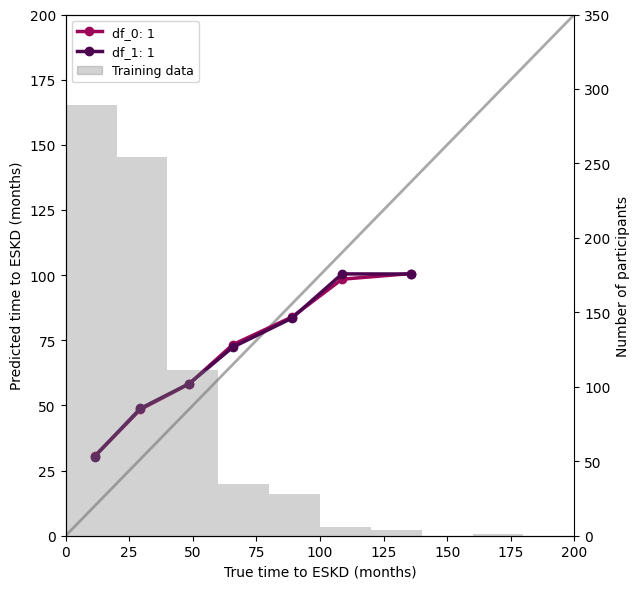


df_0:
Accuracy of censored cases predictions: 0.89 [np.float64(0.88), np.float64(0.89), np.float64(0.88), np.float64(0.93), np.float64(0.89)]
R^2: -1.05 [-1.23, -1.52, -1.09, -1.01, -0.41]
MAE: 22.9 [np.float64(22.3), np.float64(24.2), np.float64(21.6), np.float64(24.1), np.float64(22.3)]
C index: 0.87 [np.float64(0.863), np.float64(0.852), np.float64(0.865), np.float64(0.876), np.float64(0.873)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.9 [np.float64(0.88), np.float64(0.89), np.float64(0.89), np.float64(0.92), np.float64(0.9)]
R^2: -1.0 [-1.17, -1.31, -0.94, -0.92, -0.64]
MAE: 22.66 [np.float64(22.5), np.float64(23.5), np.float64(21.4), np.float64(23.0), np.float64(22.9)]
C index: 0.87 [np.float64(0.864), np.float64(0.855), np.float64(0.867), np.float64(0.878), np.float64(0.867)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [19]:
calibrate = BaggingTimeCalibrate(n_splits=5,
                                 plot_lim=(0,200),
                                 verbose=True,
                                 early_stopping_rounds=135,
                                 num_boost_round=1350)
random_state = [1]
params = {'aft_loss_distribution': ['extreme'],
          'aft_loss_distribution_scale': [0.1],
          'subset_fraction': [1.0],
          'n_models': [50]
         }
calibration_results = calibrate.bagging_grid_search(dfs = [df_train_0, df_train_1],
                                                    params = params,
                                                    random_states = random_state,
                                                    labelcols = labelcols,
                                                    line_colors = ['xkcd:dark fuchsia', 'xkcd:plum purple', 'xkcd:medium pink'])

{'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'aft_loss_distribution': 'extreme', 'aft_loss_distribution_scale': 0.1, 'tree_method': 'hist', 'learning_rate': 0.01, 'max_depth': [8, 10], 'booster': 'gbtree', 'subsample': 1.0, 'min_child_weight': 1.0, 'colsample_bynode': 1.0, 'n_models': 30, 'subset_fraction': 1.0}
{'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'aft_loss_distribution': 'extreme', 'aft_loss_distribution_scale': 0.1, 'tree_method': 'hist', 'learning_rate': 0.01, 'max_depth': [8, 10], 'booster': 'gbtree', 'subsample': 1.0, 'min_child_weight': 1.0, 'colsample_bynode': 1.0, 'n_models': 50, 'subset_fraction': 1.0}


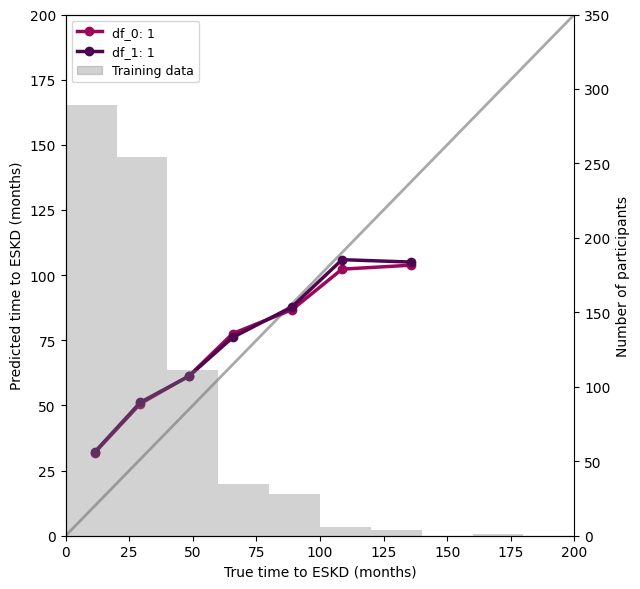


df_0:
Accuracy of censored cases predictions: 0.91 [np.float64(0.89), np.float64(0.9), np.float64(0.9), np.float64(0.93), np.float64(0.91)]
R^2: -1.34 [-1.48, -1.84, -1.41, -1.32, -0.66]
MAE: 24.56 [np.float64(23.7), np.float64(25.4), np.float64(23.7), np.float64(25.9), np.float64(24.1)]
C index: 0.87 [np.float64(0.863), np.float64(0.853), np.float64(0.864), np.float64(0.874), np.float64(0.873)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.91 [np.float64(0.9), np.float64(0.9), np.float64(0.9), np.float64(0.93), np.float64(0.91)]
R^2: -1.32 [-1.54, -1.6, -1.24, -1.33, -0.91]
MAE: 24.46 [np.float64(24.3), np.float64(25.0), np.float64(22.8), np.float64(25.2), np.float64(25.0)]
C index: 0.87 [np.float64(0.864), np.float64(0.857), np.float64(0.866), np.float64(0.877), np.float64(0.867)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [20]:
calibrate = BaggingTimeCalibrate(n_splits=5,
                                 plot_lim=(0,200),
                                 verbose=True,
                                 early_stopping_rounds=165,
                                 num_boost_round=1650)
random_state = [1]
params = {'aft_loss_distribution': ['extreme'],
          'aft_loss_distribution_scale': [0.1],
          'subset_fraction': [1.0],
          'n_models': [50]
         }
calibration_results = calibrate.bagging_grid_search(dfs = [df_train_0, df_train_1],
                                                    params = params,
                                                    random_states = random_state,
                                                    labelcols = labelcols,
                                                    line_colors = ['xkcd:dark fuchsia', 'xkcd:plum purple', 'xkcd:medium pink'])

{'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'aft_loss_distribution': 'extreme', 'aft_loss_distribution_scale': 0.1, 'tree_method': 'hist', 'learning_rate': 0.01, 'max_depth': [8, 10], 'booster': 'gbtree', 'subsample': 1.0, 'min_child_weight': 1.0, 'colsample_bynode': 1.0, 'n_models': 30, 'subset_fraction': 1.0}
{'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'aft_loss_distribution': 'extreme', 'aft_loss_distribution_scale': 0.1, 'tree_method': 'hist', 'learning_rate': 0.01, 'max_depth': [8, 10], 'booster': 'gbtree', 'subsample': 1.0, 'min_child_weight': 1.0, 'colsample_bynode': 1.0, 'n_models': 50, 'subset_fraction': 1.0}


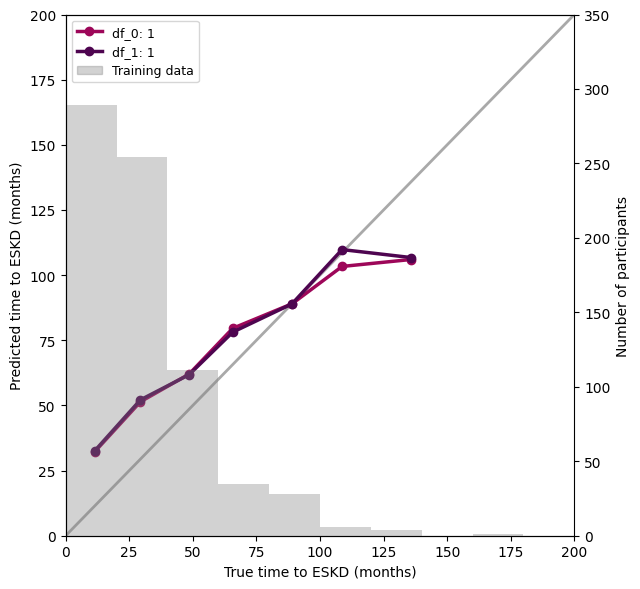


df_0:
Accuracy of censored cases predictions: 0.91 [np.float64(0.9), np.float64(0.9), np.float64(0.9), np.float64(0.93), np.float64(0.92)]
R^2: -1.44 [-1.64, -2.06, -1.49, -1.38, -0.65]
MAE: 25.02 [np.float64(24.3), np.float64(26.4), np.float64(24.2), np.float64(25.9), np.float64(24.3)]
C index: 0.87 [np.float64(0.865), np.float64(0.854), np.float64(0.867), np.float64(0.875), np.float64(0.876)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.91 [np.float64(0.9), np.float64(0.9), np.float64(0.91), np.float64(0.93), np.float64(0.91)]
R^2: -1.47 [-1.69, -1.85, -1.38, -1.42, -0.99]
MAE: 25.1 [np.float64(24.7), np.float64(26.1), np.float64(23.7), np.float64(25.5), np.float64(25.5)]
C index: 0.87 [np.float64(0.864), np.float64(0.856), np.float64(0.866), np.float64(0.877), np.float64(0.867)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [17]:
calibrate = BaggingTimeCalibrate(n_splits=5,
                                 plot_lim=(0,200),
                                 verbose=True,
                                 early_stopping_rounds=175,
                                 num_boost_round=1750)
random_state = [1]
params = {'aft_loss_distribution': ['extreme'],
          'aft_loss_distribution_scale': [0.1],
          'subset_fraction': [1.0],
          'n_models': [50]
         }
calibration_results = calibrate.bagging_grid_search(dfs = [df_train_0, df_train_1],
                                                    params = params,
                                                    random_states = random_state,
                                                    labelcols = labelcols,
                                                    line_colors = ['xkcd:dark fuchsia', 'xkcd:plum purple', 'xkcd:medium pink'])

{'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'aft_loss_distribution': 'extreme', 'aft_loss_distribution_scale': 0.1, 'tree_method': 'hist', 'learning_rate': 0.01, 'max_depth': [8, 10], 'booster': 'gbtree', 'subsample': 1.0, 'min_child_weight': 1.0, 'colsample_bynode': 1.0, 'n_models': 30, 'subset_fraction': 1.0}
{'objective': 'survival:aft', 'eval_metric': 'aft-nloglik', 'aft_loss_distribution': 'extreme', 'aft_loss_distribution_scale': 0.1, 'tree_method': 'hist', 'learning_rate': 0.01, 'max_depth': [8, 10], 'booster': 'gbtree', 'subsample': 1.0, 'min_child_weight': 1.0, 'colsample_bynode': 1.0, 'n_models': 50, 'subset_fraction': 1.0}


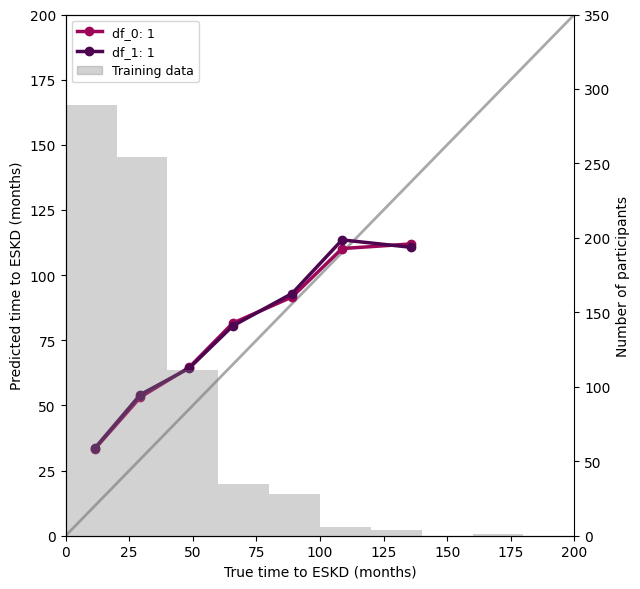


df_0:
Accuracy of censored cases predictions: 0.92 [np.float64(0.91), np.float64(0.91), np.float64(0.92), np.float64(0.94), np.float64(0.92)]
R^2: -1.74 [-1.99, -2.35, -1.91, -1.59, -0.87]
MAE: 26.38 [np.float64(25.8), np.float64(27.8), np.float64(25.5), np.float64(27.1), np.float64(25.7)]
C index: 0.87 [np.float64(0.862), np.float64(0.854), np.float64(0.863), np.float64(0.877), np.float64(0.876)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


df_1:
Accuracy of censored cases predictions: 0.92 [np.float64(0.91), np.float64(0.91), np.float64(0.92), np.float64(0.94), np.float64(0.92)]
R^2: -1.77 [-2.06, -2.06, -1.65, -1.76, -1.31]
MAE: 26.52 [np.float64(26.2), np.float64(27.1), np.float64(24.7), np.float64(27.2), np.float64(27.4)]
C index: 0.87 [np.float64(0.865), np.float64(0.858), np.float64(0.867), np.float64(0.876), np.float64(0.863)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [18]:
calibrate = BaggingTimeCalibrate(n_splits=5,
                                 plot_lim=(0,200),
                                 verbose=True,
                                 early_stopping_rounds=200,
                                 num_boost_round=2000)
random_state = [1]
params = {'aft_loss_distribution': ['extreme'],
          'aft_loss_distribution_scale': [0.1],
          'subset_fraction': [1.0],
          'n_models': [50]
         }
calibration_results = calibrate.bagging_grid_search(dfs = [df_train_0, df_train_1],
                                                    params = params,
                                                    random_states = random_state,
                                                    labelcols = labelcols,
                                                    line_colors = ['xkcd:dark fuchsia', 'xkcd:plum purple', 'xkcd:medium pink'])

In [12]:
import json

with open('raw_results/calibration_results.json', 'w') as f:
    f.write(json.dumps(calibration_results))